In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-disease-deep-learning-dataset/dataset/labels.csv
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/623.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/208.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/473.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/333.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/537.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/45.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/369.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/56.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/654.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/89.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/20.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/275.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/212.jpg
/kaggle/input/

# Importing Modules

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
import random
import albumentations as A
from tqdm import tqdm

# Dataset Loading

In [32]:
img_dir = '/kaggle/input/eye-disease-deep-learning-dataset/dataset/images'

csv_url = '/kaggle/input/eye-disease-deep-learning-dataset/dataset/labels.csv'
df = pd.read_csv(csv_url)
df.head(10)

name  category  type  grade
0   1.jpg         0     4      3
1   2.jpg         0     4      3
2   3.jpg         0     2      2
3   4.jpg         0     2      1
4   5.jpg         0     1      3
5   6.jpg         0     1      3
6   7.jpg         0     1      3
7   8.jpg         0     2      3
8   9.jpg         0     0      0
9  10.jpg         0     1      2

# EDA

In [33]:
df.shape

(712, 4)

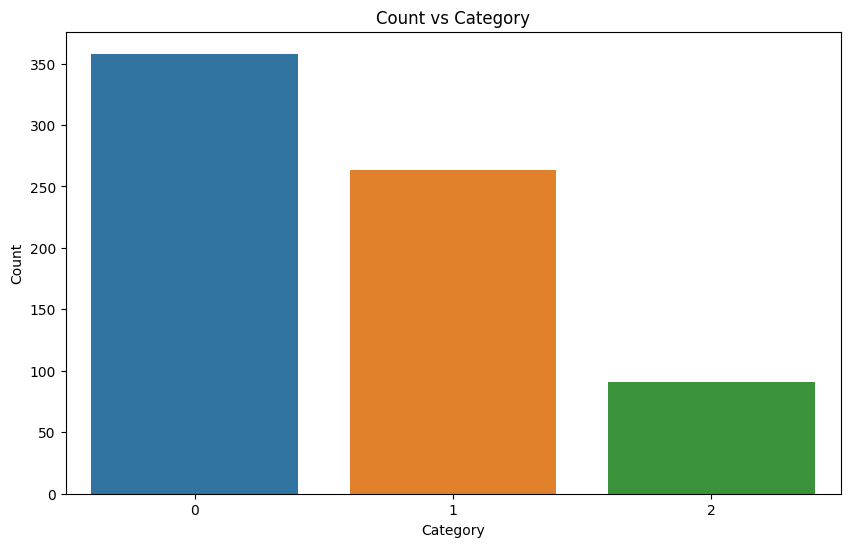

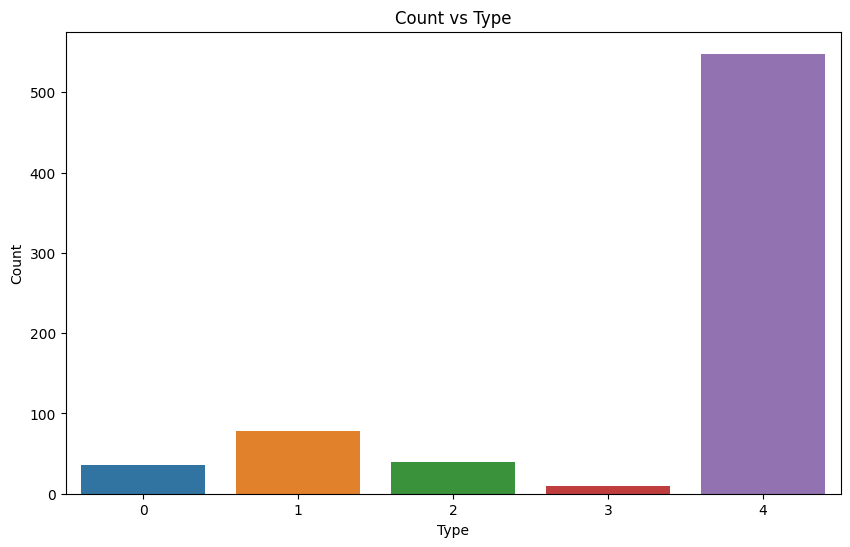

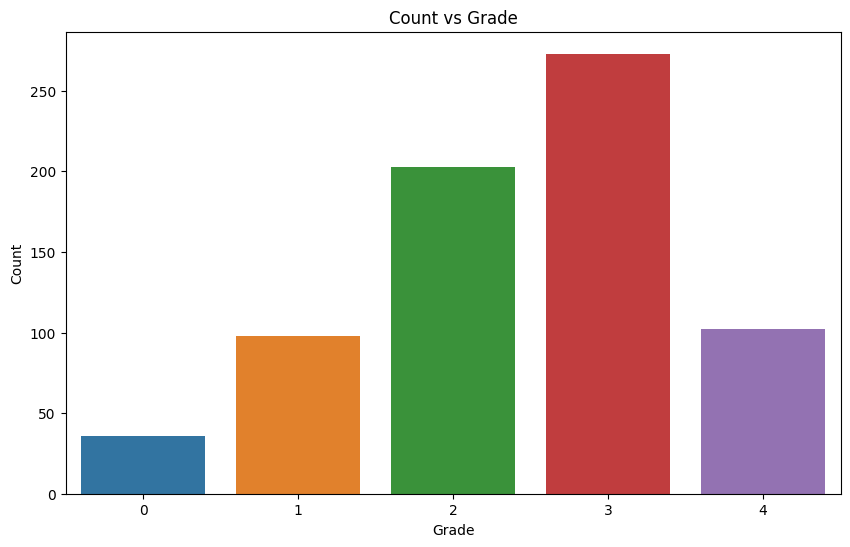

In [34]:
# Bar plot for count vs category
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category')
plt.title('Count vs Category')
plt.ylabel('Count')
plt.xlabel('Category')
plt.show()

# Bar plot for count vs type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type')
plt.title('Count vs Type')
plt.ylabel('Count')
plt.xlabel('Type')
plt.show()

# Bar plot for count vs grade
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.title('Count vs Grade')
plt.ylabel('Count')
plt.xlabel('Grade')
plt.show()

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      712 non-null    object
 1   category  712 non-null    int64 
 2   type      712 non-null    int64 
 3   grade     712 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 22.4+ KB


# Data Augmentation

In [36]:
save_dir = 'augmented_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.RandomResizedCrop(224, 224, scale=(0.9, 1.0), p=0.7),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
    A.ChannelShuffle(p=0.3),
])

num_augments = 4

aug_labels = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(img_dir, row['name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if image is None:
        print(f"Could not load image: {img_path}")
        continue

    for n in range(num_augments):
        augmented = transform(image=image)["image"]
        augmented_file_name = f"aug_{n}_{row['name']}"
        save_path = os.path.join(save_dir, augmented_file_name)

        cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

        aug_labels.append({
            'name': augmented_file_name,
            'category': row['category'],
            'type': row['type'],
            'grade': row['grade']
        })

aug_df = pd.DataFrame(aug_labels)
combined_df = pd.concat([df, aug_df], ignore_index=True)
combined_df

100%|██████████| 712/712 [01:53<00:00,  6.30it/s]


name  category  type  grade
0             1.jpg         0     4      3
1             2.jpg         0     4      3
2             3.jpg         0     2      2
3             4.jpg         0     2      1
4             5.jpg         0     1      3
...             ...       ...   ...    ...
3555  aug_3_711.jpg         2     3      4
3556  aug_0_712.jpg         2     4      4
3557  aug_1_712.jpg         2     4      4
3558  aug_2_712.jpg         2     4      4
3559  aug_3_712.jpg         2     4      4

[3560 rows x 4 columns]

In [37]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      3560 non-null   object
 1   category  3560 non-null   int64 
 2   type      3560 non-null   int64 
 3   grade     3560 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 111.4+ KB


# Augmented Data EDA

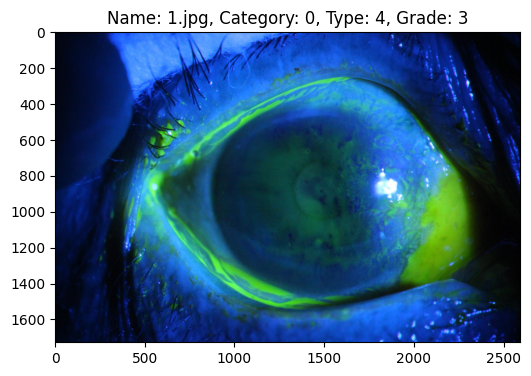

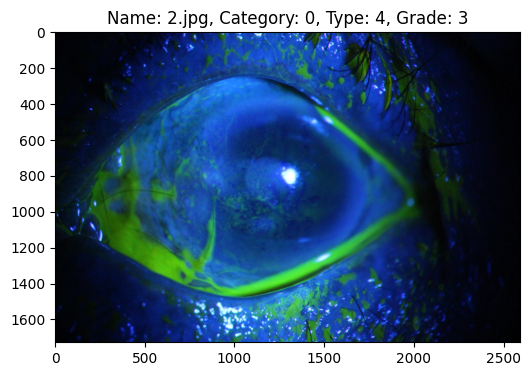

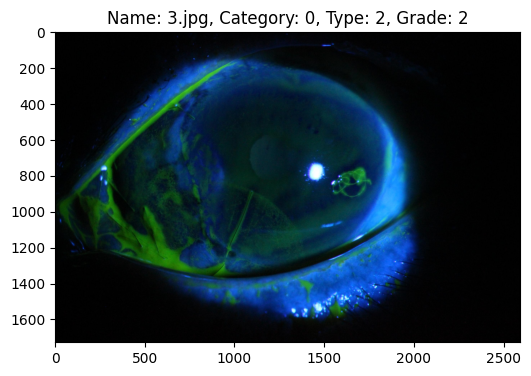

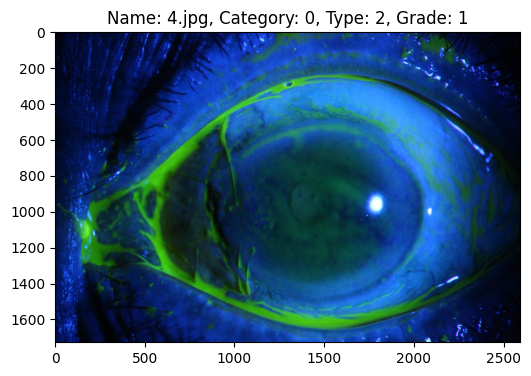

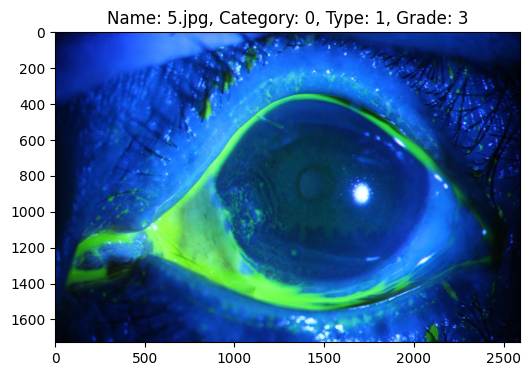

In [38]:
for idx in range(0, 5):
    if "aug" in combined_df.loc[idx, 'name']:
        save_dir = '/kaggle/working/augmented_images'
    else:
        save_dir = '/kaggle/input/eye-disease-deep-learning-dataset/dataset/images'
    img_path = os.path.join(save_dir, combined_df.loc[idx, 'name'])  # save_dir for augmented images
    image = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    title = f"Name: {combined_df.loc[idx, 'name']}, Category: {combined_df.loc[idx, 'category']}, Type: {combined_df.loc[idx, 'type']}, Grade: {combined_df.loc[idx, 'grade']}"
    plt.title(title)
    plt.show()
    plt.close()

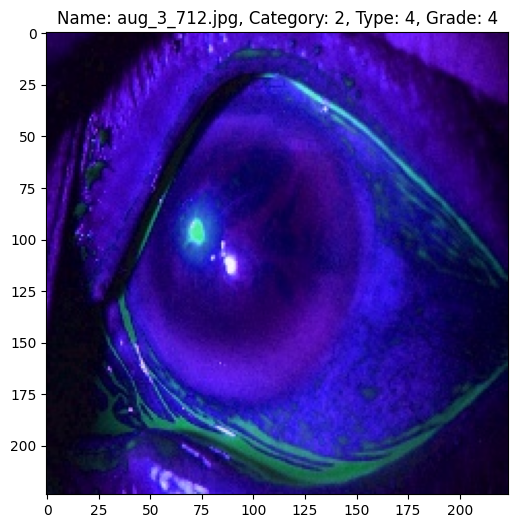

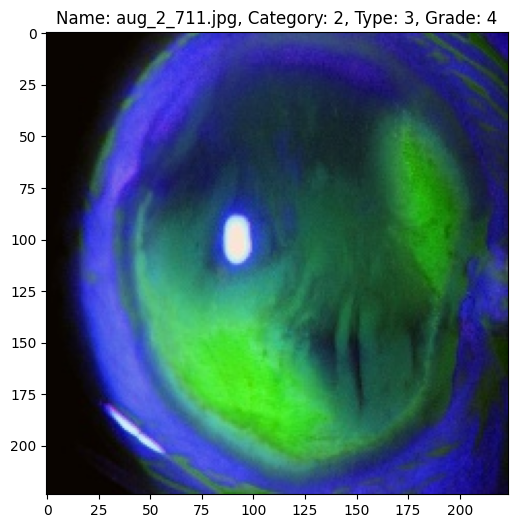

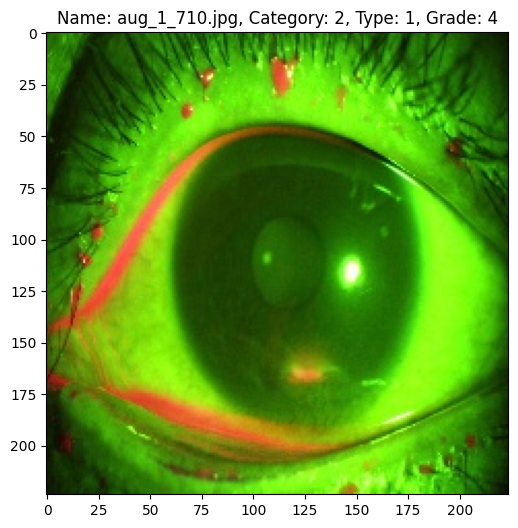

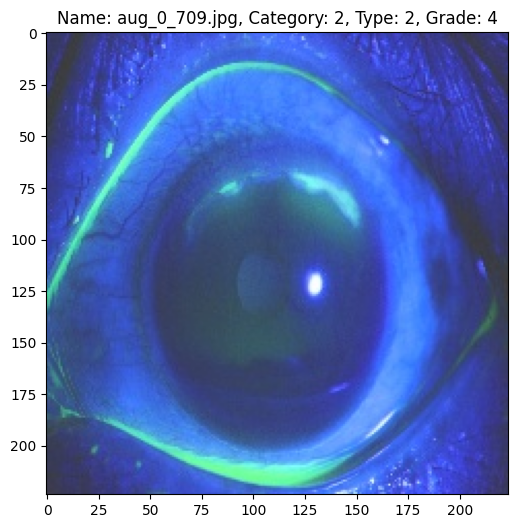

In [39]:
for idx in range(len(combined_df) - 1, len(combined_df)-20, -5):
    if "aug" in combined_df.loc[idx, 'name']:
        save_dir = '/kaggle/working/augmented_images'
    else:
        save_dir = '/kaggle/input/eye-disease-deep-learning-dataset/dataset/images'
    img_path = os.path.join(save_dir, combined_df.loc[idx, 'name'])  # save_dir for augmented images
    image = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    title = f"Name: {combined_df.loc[idx, 'name']}, Category: {combined_df.loc[idx, 'category']}, Type: {combined_df.loc[idx, 'type']}, Grade: {combined_df.loc[idx, 'grade']}"
    plt.title(title)
    plt.show()
    plt.close()

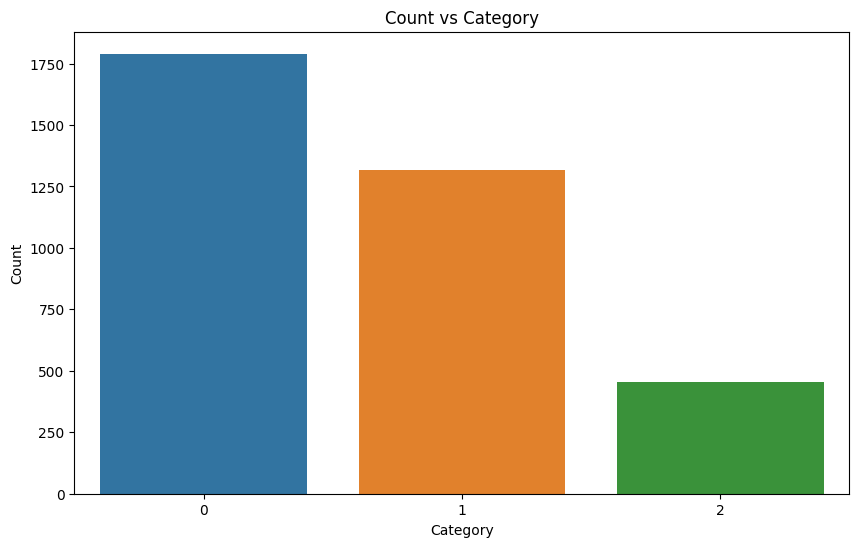

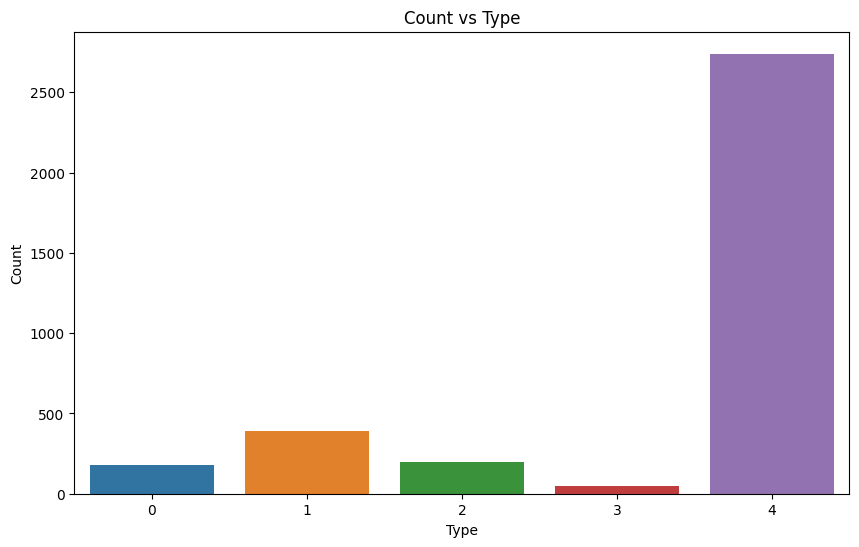

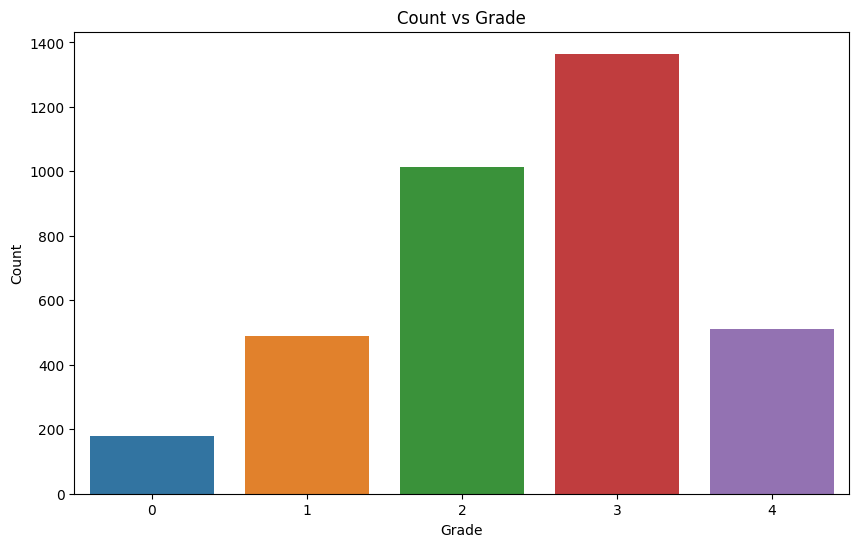

In [40]:
# Bar plot for count vs category
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='category')
plt.title('Count vs Category')
plt.ylabel('Count')
plt.xlabel('Category')
plt.show()

# Bar plot for count vs type
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='type')
plt.title('Count vs Type')
plt.ylabel('Count')
plt.xlabel('Type')
plt.show()

# Bar plot for count vs grade
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='grade')
plt.title('Count vs Grade')
plt.ylabel('Count')
plt.xlabel('Grade')
plt.show()

# Single Output Model Building

In [41]:
def build_custom_transfer_model(num_classes, base_model_name):
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)

    if base_model_name == "EfficientNetB0":
        base = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    elif base_model_name == "ResNet50":
        base = ResNet50(include_top=False, input_tensor=inputs, weights='imagenet')
    elif base_model_name == "MobileNetV2":
        base = MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')

    base.trainable = False

    # Custom top layers
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
from sklearn.utils import class_weight
def train_model(X_train, y_train, num_classes, base_model_name):
    
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights_array))
    
    model = build_custom_transfer_model(num_classes, base_model_name)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1, class_weight = class_weights)

    return model, history

In [43]:
img_arrays = []

for idx in range(combined_df.shape[0]):
    if "aug" in combined_df.loc[idx, 'name']:
        save_dir = '/kaggle/working/augmented_images'
    else:
        save_dir = '/kaggle/input/eye-disease-deep-learning-dataset/dataset/images'

    img_path = os.path.join(save_dir, combined_df.loc[idx, 'name'])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    
    # Convert to array and normalize
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    
    img_arrays.append(img)

images_arrays = np.array(img_arrays)

In [44]:
def plot_acc_graphs(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Category Label

In [45]:
num_classes = combined_df['category'].nunique()
X_train, X_test , y_train, y_test = train_test_split(images_arrays, combined_df['category'].values, test_size=0.3, stratify=combined_df['category'].values, random_state=42)

In [46]:
category_model, category_history = train_model(X_train, y_train, num_classes, "EfficientNetB0")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 423ms/step - accuracy: 0.3521 - loss: 1.7811 - val_accuracy: 0.5050 - val_loss: 1.0969
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2948 - loss: 1.4226 - val_accuracy: 0.5050 - val_loss: 1.0885
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3377 - loss: 1.3265 - val_accuracy: 0.5050 - val_loss: 1.0946
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3448 - loss: 1.3251 - val_accuracy: 0.5050 - val_loss: 1.0929
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3469 - loss: 1.3057 - val_accuracy: 0.5050 - val_loss: 1.0561
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3271 - loss: 1.2365 - val_accuracy: 0.4509 - val_loss: 1.0659
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3309 - loss: 1.2600 - val_accuracy: 0.1303 - val_loss: 1.1137
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3243 - loss: 1.2655 - val_accuracy: 0.5050 -

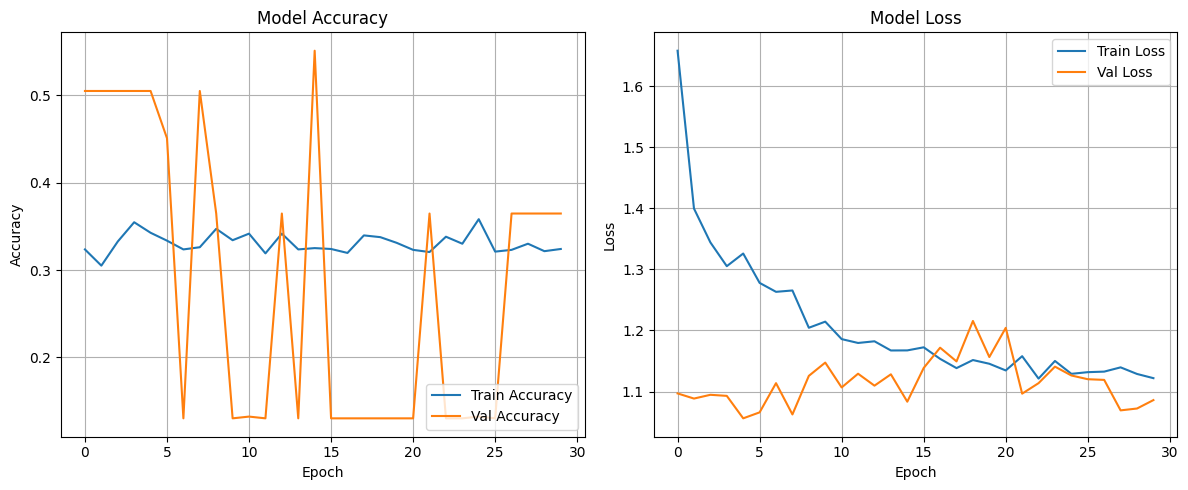

In [47]:
plot_acc_graphs(category_history)

In [48]:
category_model, category_history = train_model(X_train, y_train, num_classes, "ResNet50")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - accuracy: 0.4507 - loss: 1.4795 - val_accuracy: 0.5050 - val_loss: 1.0931
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.5307 - loss: 1.0775 - val_accuracy: 0.5050 - val_loss: 0.9865
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5813 - loss: 0.9114 - val_accuracy: 0.4228 - val_loss: 0.9912
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5754 - loss: 0.9428 - val_accuracy: 0.4168 - val_loss: 0.9776
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.6292 - loss: 0.8683 - val_accuracy: 0.4028 - val_loss: 1.0076
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6402 - loss: 0.8139 - val_accuracy: 0.3808 - val_loss: 1.0344
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.6708 - loss: 0.7663 - val_accuracy: 0.4790 - val_loss: 0.9565
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step 

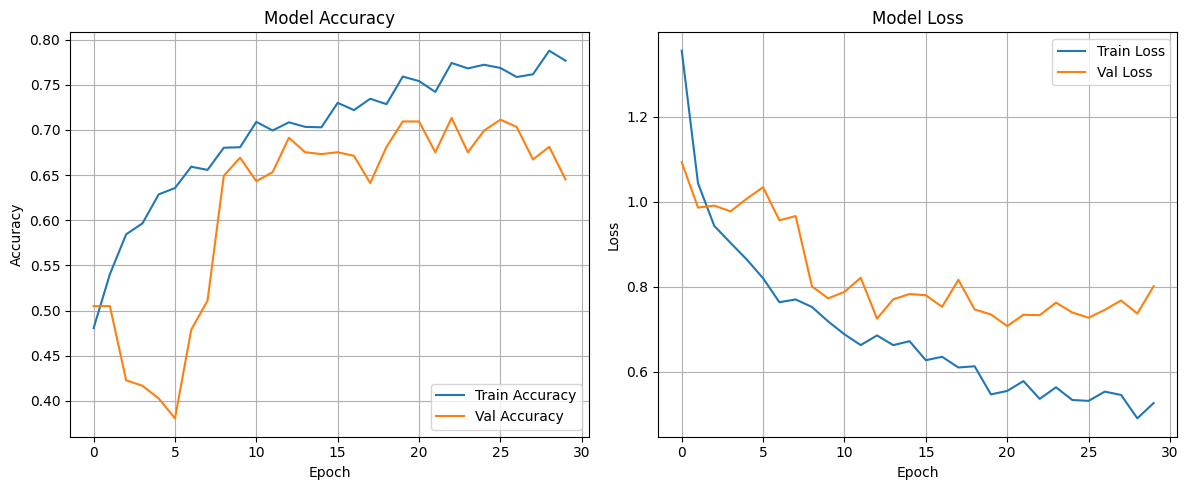

In [49]:
plot_acc_graphs(category_history)

In [50]:
category_model, category_history = train_model(X_train, y_train, num_classes, "MobileNetV2")

<ipython-input-41-78e154f2706e>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.4886 - loss: 1.4463 - val_accuracy: 0.5631 - val_loss: 0.9746
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7233 - loss: 0.6277 - val_accuracy: 0.7375 - val_loss: 0.6362
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7714 - loss: 0.5071 - val_accuracy: 0.7595 - val_loss: 0.5885
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8233 - loss: 0.3905 - val_accuracy: 0.7715 - val_loss: 0.5549
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8533 - loss: 0.3298 - val_accuracy: 0.7796 - val_loss: 0.5372
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8849 - loss: 0.2748 - val_accuracy: 0.7936 - val_loss: 0.5360
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8870 - loss: 0.2790 - val_accuracy: 0.8136 - val_loss: 0.5046
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accurac

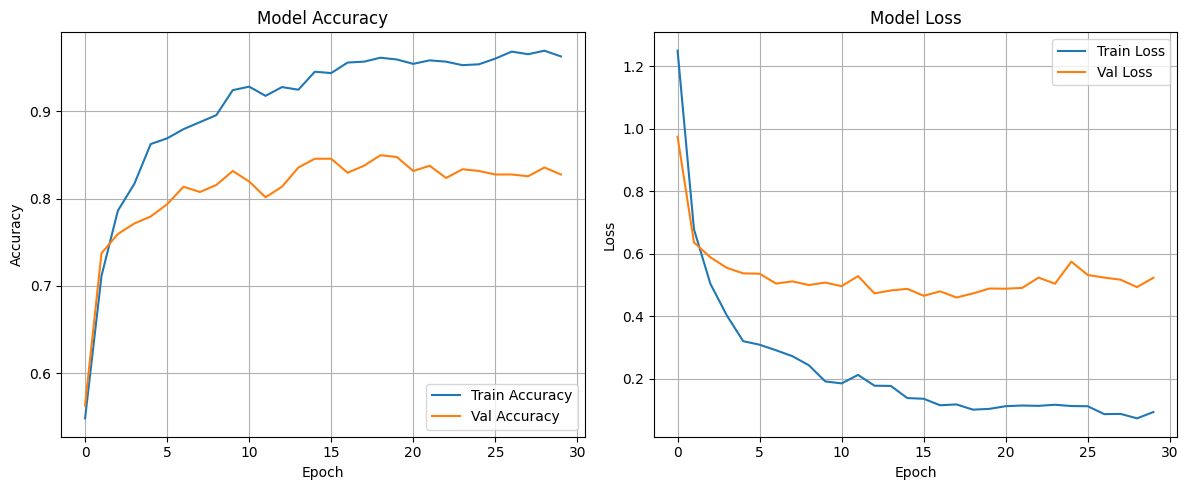

In [51]:
plot_acc_graphs(category_history)

**MobileNetV2 is the best performing model for Category label**

In [26]:
loss, acc = category_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8591 - loss: 0.4876
Test Loss: 0.5364
Test Accuracy: 0.8455


In [27]:
y_pred_probs = category_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) 
print(classification_report(y_test, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       537
           1       0.84      0.82      0.83       395
           2       0.70      0.65      0.67       136

    accuracy                           0.85      1068
   macro avg       0.81      0.79      0.80      1068
weighted avg       0.84      0.85      0.84      1068



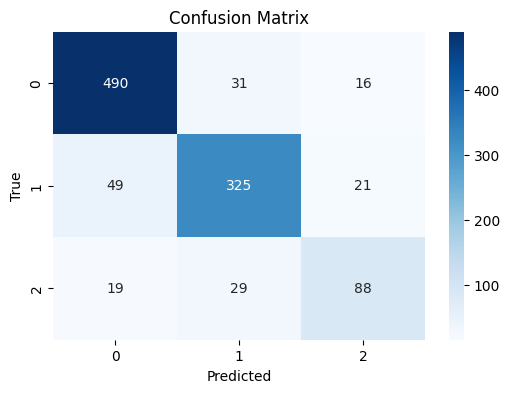

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Type Label

In [32]:
num_classes = combined_df['type'].nunique()
X_train, X_test, y_train, y_test = train_test_split(images_arrays, combined_df['type'].values, test_size=0.3, stratify=combined_df['type'].values, random_state=42)

In [33]:
type_model, type_history = train_model(X_train, y_train, num_classes, "EfficientNetB0")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.1753 - loss: 2.6324 - val_accuracy: 0.0140 - val_loss: 1.6816
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.1793 - loss: 2.1406 - val_accuracy: 0.0140 - val_loss: 1.6869
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1918 - loss: 1.9839 - val_accuracy: 0.0140 - val_loss: 1.6985
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1986 - loss: 2.0345 - val_accuracy: 0.0140 - val_loss: 1.9602
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1542 - loss: 1.8668 - val_accuracy: 0.0140 - val_loss: 1.9765
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1906 - loss: 1.8669 - val_accuracy: 0.0140 - val_loss: 1.8967
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1880 - loss: 1.9047 - val_accuracy: 0.0140 - val_loss: 1.7050
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2080 - loss: 1.9260 - val_accuracy: 0.0140 -

In [29]:
print('hi')

hi


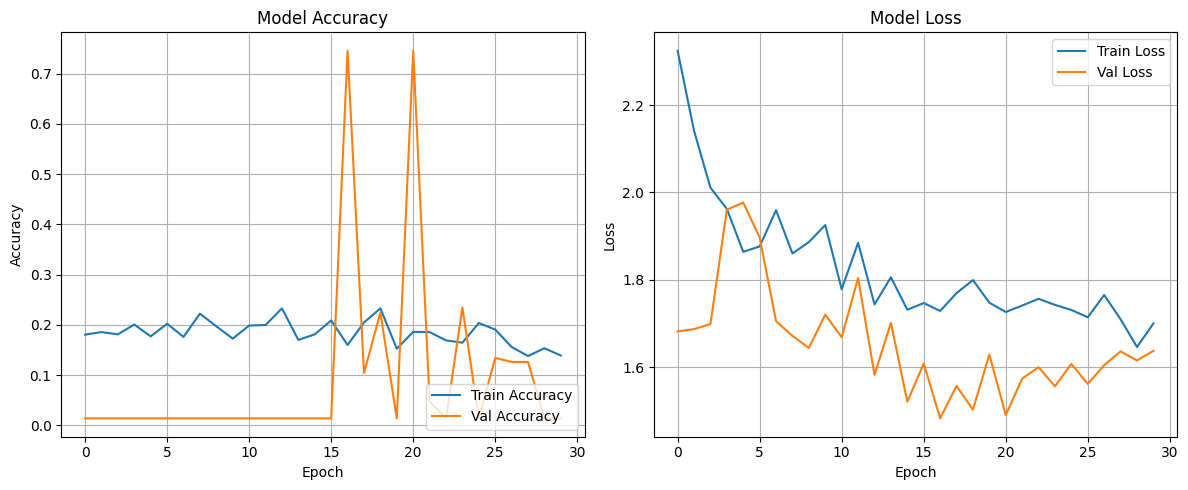

In [34]:
plot_acc_graphs(type_history)

In [35]:
type_model, type_history = train_model(X_train, y_train, num_classes, "ResNet50")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.2036 - loss: 2.3805 - val_accuracy: 0.0481 - val_loss: 1.5146
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.2569 - loss: 1.5413 - val_accuracy: 0.0762 - val_loss: 1.4187
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.3328 - loss: 1.2680 - val_accuracy: 0.2565 - val_loss: 1.3389
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.3798 - loss: 1.1291 - val_accuracy: 0.4369 - val_loss: 1.3499
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4206 - loss: 1.0026 - val_accuracy: 0.5251 - val_loss: 1.3170
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.4646 - loss: 1.0113 - val_accuracy: 0.6172 - val_loss: 1.1993
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.4918 - loss: 1.0043 - val_accuracy: 0.6393 - val_loss: 1.1422
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.5026 - loss: 0.9362 - val_accuracy: 0

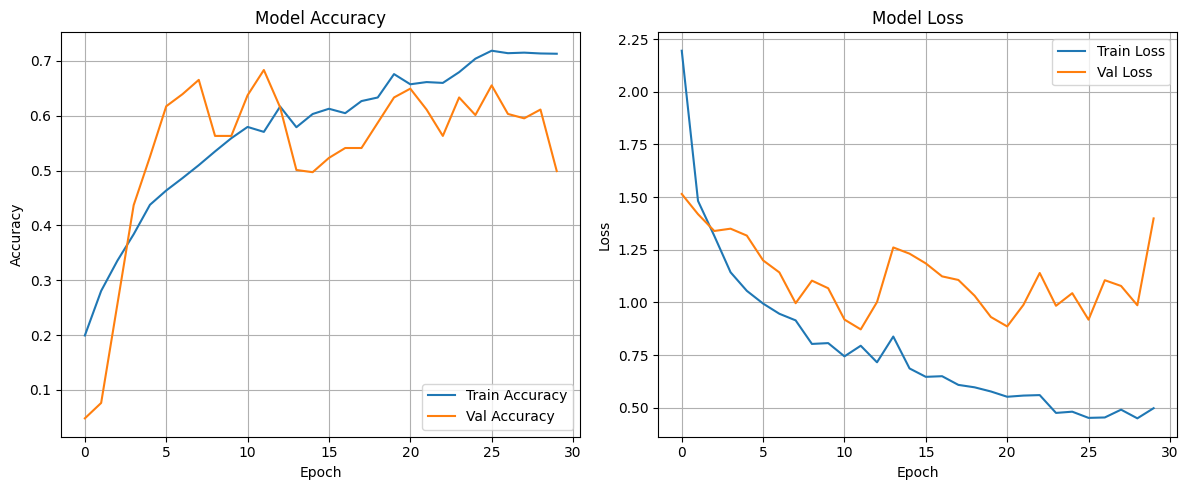

In [36]:
plot_acc_graphs(type_history)

In [37]:
type_model, type_history = train_model(X_train, y_train, num_classes, "MobileNetV2")

<ipython-input-12-78e154f2706e>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.2286 - loss: 2.1892 - val_accuracy: 0.3467 - val_loss: 1.6348
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3985 - loss: 0.8676 - val_accuracy: 0.5471 - val_loss: 1.2248
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5503 - loss: 0.5731 - val_accuracy: 0.6253 - val_loss: 1.0471
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6363 - loss: 0.4889 - val_accuracy: 0.6854 - val_loss: 0.8432
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6883 - loss: 0.3870 - val_accuracy: 0.7695 - val_loss: 0.7368
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7401 - loss: 0.3269 - val_accuracy: 0.7595 - val_loss: 0.6937
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7620 - loss: 0.2944 - val_accuracy: 0.7956 - val_loss: 0.6606
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8043 - loss: 0.2573 - val_accuracy: 0.7976 -

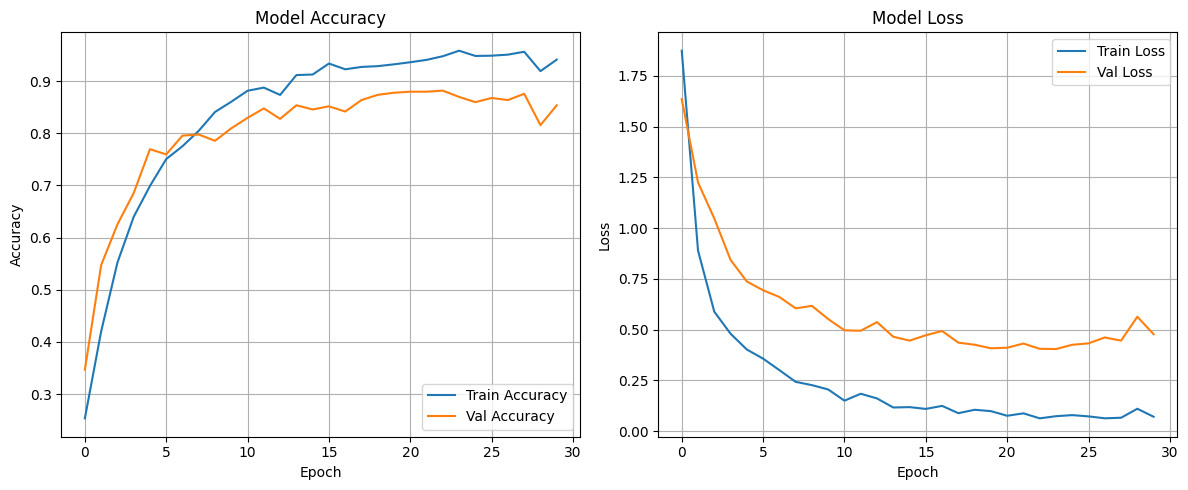

In [38]:
plot_acc_graphs(type_history)

**MobileNetV2 is performing best for Type label**

In [39]:
loss, acc = type_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8857 - loss: 0.3949
Test Loss: 0.4263
Test Accuracy: 0.8773


In [40]:
y_pred_probs = type_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) 
print(classification_report(y_test, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        54
           1       0.77      0.62      0.68       117
           2       0.63      0.65      0.64        60
           3       0.88      0.93      0.90        15
           4       0.93      0.94      0.94       822

    accuracy                           0.88      1068
   macro avg       0.75      0.76      0.76      1068
weighted avg       0.88      0.88      0.88      1068



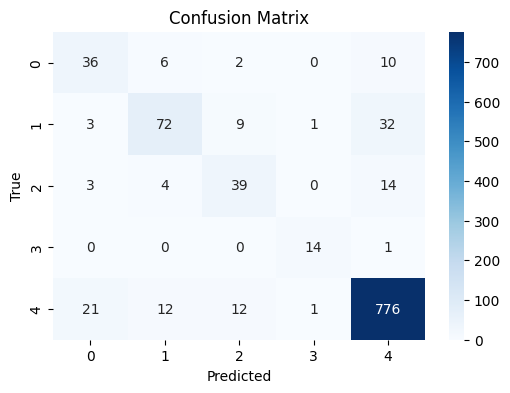

In [41]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Grade Label

In [42]:
num_classes = combined_df['grade'].nunique()
X_train, X_test, y_train, y_test = train_test_split(images_arrays, combined_df['grade'].values, test_size=0.3, stratify=combined_df['grade'].values, random_state=42)

In [43]:
grade_model, grade_history = train_model(X_train, y_train, num_classes, "EfficientNetB0")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 313ms/step - accuracy: 0.1890 - loss: 2.3649 - val_accuracy: 0.2886 - val_loss: 1.5585
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.1950 - loss: 2.0395 - val_accuracy: 0.3808 - val_loss: 1.5544
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.1952 - loss: 1.8955 - val_accuracy: 0.3808 - val_loss: 1.5407
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1751 - loss: 1.9373 - val_accuracy: 0.0381 - val_loss: 1.6086
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.1953 - loss: 1.8208 - val_accuracy: 0.3808 - val_loss: 1.5828
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2104 - loss: 1.8937 - val_accuracy: 0.3808 - val_loss: 1.6338
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1879 - loss: 1.8392 - val_accuracy: 0.3808 - val_loss: 1.5980
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1694 - loss: 1.8577 - val_accuracy: 0.1463 -

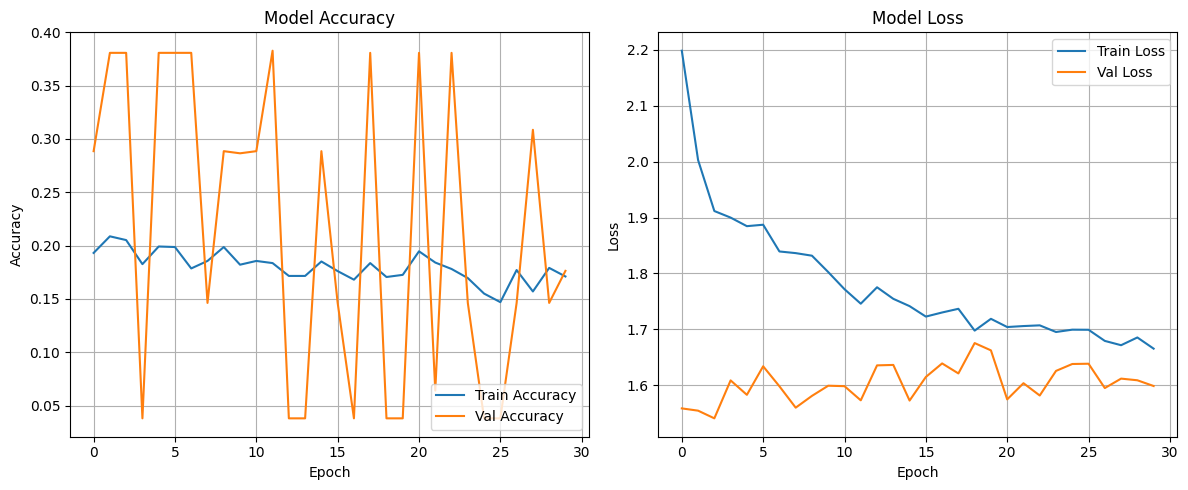

In [44]:
plot_acc_graphs(grade_history)

In [45]:
grade_model, grade_history = train_model(X_train, y_train, num_classes, "ResNet50")

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.2194 - loss: 2.2754 - val_accuracy: 0.0381 - val_loss: 1.7853
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.2991 - loss: 1.6533 - val_accuracy: 0.0381 - val_loss: 1.8808
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.3751 - loss: 1.4507 - val_accuracy: 0.0441 - val_loss: 1.7552
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.3567 - loss: 1.4606 - val_accuracy: 0.2485 - val_loss: 1.5941
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4167 - loss: 1.3719 - val_accuracy: 0.3086 - val_loss: 1.5557
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.4224 - loss: 1.2865 - val_accuracy: 0.3928 - val_loss: 1.4926
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.4085 - loss: 1.2354 - val_accuracy: 0.4429 - val_loss: 1.3484
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.4527 - loss: 1.2034 - val_accuracy: 0

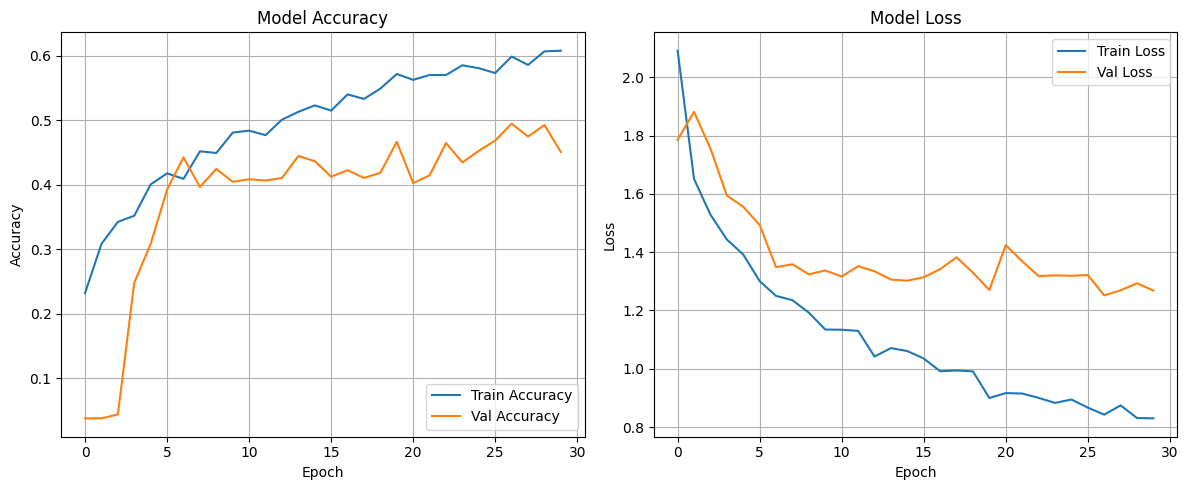

In [46]:
plot_acc_graphs(grade_history)

In [47]:
grade_model, grade_history = train_model(X_train, y_train, num_classes, "MobileNetV2")

<ipython-input-12-78e154f2706e>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.2896 - loss: 2.2185 - val_accuracy: 0.3868 - val_loss: 1.4611
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5089 - loss: 1.1666 - val_accuracy: 0.5210 - val_loss: 1.1939
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6022 - loss: 0.8872 - val_accuracy: 0.5491 - val_loss: 1.1183
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6711 - loss: 0.7008 - val_accuracy: 0.6112 - val_loss: 0.9948
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7167 - loss: 0.6087 - val_accuracy: 0.6473 - val_loss: 0.8923
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7646 - loss: 0.5069 - val_accuracy: 0.6273 - val_loss: 0.8839
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7846 - loss: 0.4753 - val_accuracy: 0.6513 - val_loss: 0.8858
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8081 - loss: 0.4180 - val_accuracy: 0.6854 -

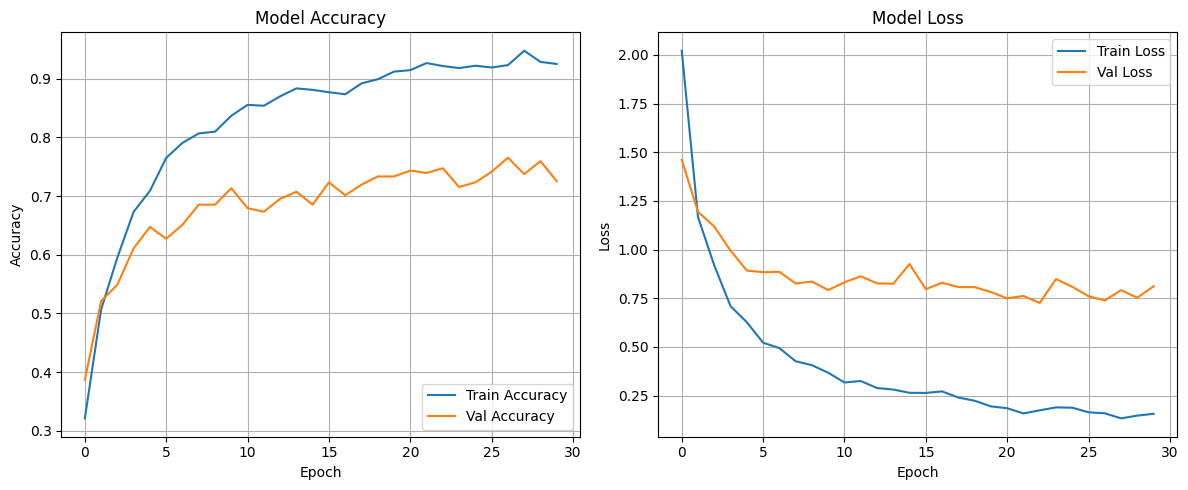

In [48]:
plot_acc_graphs(grade_history)

**MobileNetV2 provides the best validation accuracy for grade label**

In [49]:
loss, acc = grade_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7534 - loss: 0.7889
Test Loss: 0.8519
Test Accuracy: 0.7275


In [50]:
y_pred_probs = grade_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) 
print(classification_report(y_test, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        54
           1       0.73      0.58      0.64       147
           2       0.71      0.70      0.71       305
           3       0.76      0.78      0.77       409
           4       0.70      0.77      0.74       153

    accuracy                           0.73      1068
   macro avg       0.71      0.71      0.71      1068
weighted avg       0.73      0.73      0.73      1068



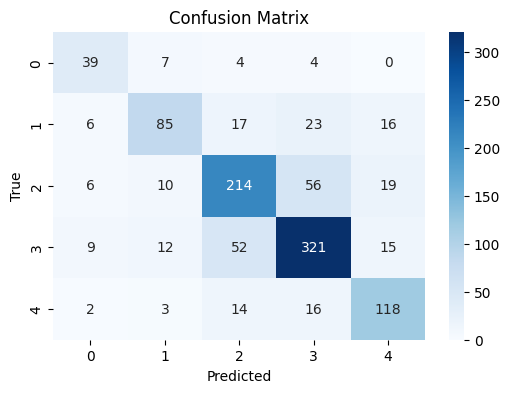

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#  Multi-output Model

In [ ]:
def build_custom_multioutput_model(num_classes, base_model_name):
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)

    if base_model_name == "EfficientNetB0":
        base = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    elif base_model_name == "ResNet50":
        base = ResNet50(include_top=False, input_tensor=inputs, weights='imagenet')
    elif base_model_name == "MobileNetV2":
        base = MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')

    base.trainable = False

    # Custom top layers
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    category_output = Dense(num_classes['category'], activation='softmax', name='category')(x)
    type_output = Dense(num_classes['type'], activation='softmax', name='type')(x)
    grade_output = Dense(num_classes['grade'], activation='softmax', name='grade')(x)

    model = Model(inputs=inputs, outputs=[category_output, type_output, grade_output])
    return model

In [ ]:
from sklearn.utils import class_weight
def train_multioutput_model(X_train, y_train, num_classes, base_model_name):

    y_train_category, y_train_type, y_train_grade = y_train[:, 0], y_train[:, 1], y_train[:, 2]
    
    model = build_custom_multioutput_model(num_classes, base_model_name)
    model.compile(
        optimizer='adam',
        loss={
            'category': 'sparse_categorical_crossentropy',
            'type': 'sparse_categorical_crossentropy',
            'grade': 'sparse_categorical_crossentropy'
        },
        metrics={
            'category': 'accuracy',
            'type': 'accuracy',
            'grade': 'accuracy'
        }
    )

    history = model.fit(
        X_train,
        {
        'category': y_train_category,
        'type': y_train_type,
        'grade': y_train_grade
        }, 
        validation_split=0.2, epochs=30, batch_size=32, verbose=1)

    return model, history

In [ ]:
num_classes = {'category': combined_df['category'].nunique(),
                    'type': combined_df['type'].nunique(),
                    'grade': combined_df['grade'].nunique()
                   }

y_category = combined_df['category'].values
y_type = combined_df['type'].values
y_grade = combined_df['grade'].values

# Stack the labels together temporarily for the split
y_combined = np.stack([y_category, y_type, y_grade], axis=1)

X_train, X_test, y_train, y_test = train_test_split(images_arrays, y_combined, test_size=0.3, stratify=combined_df['category'].values, random_state=42)

multioutput_model, multioutput_history = train_multioutput_model(X_train, y_train, num_classes, "MobileNetV2")

In [ ]:
def plot_acc_graphs(history):
    plt.figure(figsize=(18, 10))

    outputs = ['category', 'type', 'grade']
    
    for i, label in enumerate(outputs):
        # Accuracy
        plt.subplot(3, 2, 2 * i + 1)
        plt.plot(history.history[f'{label}_accuracy'], label='Train Accuracy')
        plt.plot(history.history[f'val_{label}_accuracy'], label='Val Accuracy')
        plt.title(f'{label.capitalize()} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True)

        # Loss
        plt.subplot(3, 2, 2 * i + 2)
        plt.plot(history.history[f'{label}_loss'], label='Train Loss')
        plt.plot(history.history[f'val_{label}_loss'], label='Val Loss')
        plt.title(f'{label.capitalize()} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_acc_graphs(multioutput_history)